In [947]:
import numpy as np
from numpy.linalg import inv   #if needed
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import scipy.special
# from scipy.special import eval_legendre, eval_hermitenorm

#Polynomial Chaos E. terms ----------------------------------------------

def hermite(x,n):
    return eval_hermitenorm(n,x)/np.sqrt(scipy.special.factorial(n))

def legendre(x,n):
    return eval_legendre(n,x)*np.sqrt(2*n+1)

def scalelegendre(x,new_min,new_max): 
    return ((new_min+new_max)+((new_max-new_min)*x))/2

def scalehermite(x,mean,sigma):
    return mean+sigma*x

def NORMleg1(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))

def PCE(x1,alpha,Y_):
    M_= 0
        
    for j in range (0,len(alpha)):
           
        M_ = M_ + Y_[j] * M1(x1,alpha[j,0]) #* M2(x2,alpha[j,1])  #M1 legendre / M2 hermite

    return M_

#Kriging ----------------------------------------------

# def distance1D(x,xk):
#     return x.reshape(-1,1)-xk.reshape(1,-1)

def distance(x,xk):                        #multidimensional distance between 2 samples
    d=np.zeros((len(x),len(xk)))
    
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j]+np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

# def euclid(r,l,scale):   # kernell squared Euclidean distance
#     return scale*np.exp(-((r)**2/(2*l**2)))

def GaussianPred(x,xn,yn,phi,Y,l,sig):
    
    cov_nn = euclid(distance(xn,xn),l,sig)             #covariance between observations
    cov_xn = euclid(distance(x,xn),l,sig)              #covariance with new points
    cov_mult=np.matmul(cov_xn,np.linalg.inv(cov_nn))   #  r'(x) * R^-1
    #--------------------------------------------------------------------------------------    
    mean=np.matmul(cov_mult,(yn-np.matmul(phi,Y)))     #mean corrected by PCE
    #-------------------------------------------------------------------------------------- 
    cov_xx=euclid(distance(x,x),l,sig)
    variance=np.subtract(cov_xx,np.matmul(cov_mult,cov_xn.transpose())) 
    variaDiag=np.diagonal(variance)
    
    return mean,variaDiag

# def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [1D array]
#     dist=abs(distance(x,xn))
#     voro=np.argmin(np.squeeze(dist))
#     return voro

In [365]:
# #ground truth function----------------------------------------------------

def functiontest(x):
#     return -(np.sin(x*7)+np.cos(14*x))*(x**2)*np.exp(-4*x)
    return x * np.sin(x)

In [19]:
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

In [376]:
def info_matrix (X,alpha):    # X must be normalized for polynomial evaluations
    
    fx = np.zeros ((len(X), len(alpha))) 
    
    for i in range (0,len(X)):
        for j in range (0, len(alpha)):
            fx[i,j]=M1(X[i,0],alpha[j,0])  #*M2(X[i,1],alpha[j,1])  ### per variable 
            
    return fx

In [366]:
#definition of input parameters----------------------------------------------

function = functiontest

dim=1       # dimensionality
n=10       # observations
ntest=500   # test points
seed=0      # fixing seed random number generator

np.random.seed(seed)         #fixing seed random number generator

xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
#-----------------------------------------------------random Variable 1

# M1=hermite                           #type of polynomial for PCE
# x1mean = 0.75                            
# x1sigma = 0.5


# xn[:,0] = np.random.normal(0,1,n)                             
# XN[:,0] = np.random.normal(0,1,ntest)  

# xr[:,0] = scalehermite(xn[:,0],x1mean,x1sigma) 
# XR[:,0] = scalehermite(XN[:,0],x1mean,x1sigma)   

M1=legendre                           #type of polynomial for PCE
x1min = 0                           #lower bound    
x1max = 15.0  

# xn[:,0] = np.random.uniform(-1,1,n)                             
# XN[:,0] = np.random.uniform(-1,1,ntest) 

# xr[:,0] = scalelegendre(xn[:,0],x1min,x1max) 
# XR[:,0] = scalelegendre(XN[:,0],x1min,x1max)   

#=====================================================
# # Evaluation of observations and test points

# y=function(xr)          #Observations
# Mtest=function(XR)

#=====================================================
# Evaluation of observations and test points

y=function(xr)          #Observations
Mtest=function(XR)


In [560]:
# # # UQ lab ----------------------------------------------
# xr = np.array([7.5000,
#                 3.7500,
#                11.2500,
#                 1.8750,
#                 9.3750,
#                 5.6250,
#                13.1250,
#                 0.9375,
#                 8.4375,
#                 4.6875]).reshape(-1,1)

# xn = NORMleg1(xr,0.0,15.0,-1,1).reshape(-1,1)

# XN[:,0] = np.random.uniform(-1,1,ntest) 
# XR[:,0] = scalelegendre(XN[:,0],x1min,x1max)   

# # # UQ lab ----------------------------------------------
# B = np.array([7.82167423543062,
# 8.91027632414198,
# 9.47412206562374,
# 7.51776716025817,
# 4.02708022628571,
# -1.60396965559462]).reshape(-1,1)

# sig2 = 61.6836

In [526]:
def matern(xr,xn,theta,v):     #Matern correlation R(xr-xn)
    
    R=np.zeros((len(xr),len(xn)))
    
    if v == 3/2:
        
        R = (1+ np.sqrt(3)*distance(xr,xn)/theta)* np.exp(-(np.sqrt(3)*distance(xr,xn)/theta))
        
    elif v == 5/2:
        
        R = ((1+ (np.sqrt(5)*distance(xr,xn)/theta) + (5/3)*(distance(xr,xn)/theta)**2 ) 
             * np.exp(-(np.sqrt(5)*distance(xr,xn)/theta)))
    return R

def fast_inv(A):
    identity = np.identity(A.shape[1], dtype=A.dtype)
    return np.linalg.solve(A, identity)

def coefficients(F,xn,y,l,v):   
    #returns B_hat and sigma^2

    R=matern(xn,xn,l,v)    # Correlation matrix R
    
    R_inv= fast_inv(R)
    left_r =  fast_inv((F.T @ R_inv) @ F)
    right_r = F.T @ R_inv @ y
    B_hat = left_r @ right_r
    #----------------------------------------------------------
    ins = y - (F @ B_hat)              # Scale sigma^2
    left_s = (1/len(xn))*((ins).T)
    right_s = R_inv @ ins
    sig2 = left_s @ right_s
    
    return  B_hat, sig2

# def PCK_pred(X,xn,y,B,sig2,l,v):
    
#     rx= matern(X,xn,l,v)
#     Rn= matern(xn,xn,l,v)
    
#     mean1 = PCE(X[:,0],X[:,1],alpha,B)  
#     mean2 = rx @ fast_inv(Rn) @ (y-(phi @ B))
#     PCKmean = mean1+mean2
    
#     return PCKmean  

In [483]:
# xa=np.linspace(0,1,100)
# dista=distance(xa,xa)
# Ra=matern(xa,xa,0.096,3/2)

# plt.figure()
# plt.plot(dista,Ra)
# plt.show

In [525]:
#truncation term
p = 5  #for each variable → same truncation , degree of expansion

indices = np.arange(0,p+1)   #polynomials indices to be combined

comb = np.zeros((p**dim,dim))

#------------------------------------------------------------------------- #all possible combinations of indices
comb = np.array(np.meshgrid(indices)).T.reshape(-1,dim)    #(indices, indices, indices...) per dimension

alpha = [] #list of product combinations with degree <= "p" (truncation term)

for i in range (0,len(comb)): 
    if (np.sum(comb[i]))<=p:  
        alpha.append(comb[i])
        
alpha = np.array(alpha) #alpha for multivariate combination

#EXPERIMENTAL MATRIX == evaluation of product combinations for multivariate function with degree <= "p"

phi = info_matrix(xn,alpha)

In [559]:
#Ordinary Least-squared estimation
phi_trans=phi.transpose()
phi_Inv=np.linalg.inv(np.matmul(phi_trans, phi))
Inv_phi_trans=np.matmul(phi_Inv,phi_trans)
Y_=np.matmul(Inv_phi_trans,y)                         #coefficients for PC =f(M) observations

In [585]:
#optimizing kernell-hyperparameters and fitting GP regressor with Scikit-learn package----------------------------
kernel = 1 * RBF(length_scale=1.5, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(xn, y)
ke= gaussian_process.kernel_
print("kernel 1   :",ke)

kernel 1   : 15**2 * RBF(length_scale=0.333)


In [582]:
# kernel hyperparameters------------------------------
# l=0.3664        #length scale
l= 0.0720764201844173
v=5/2    #matern coefficient

B, sig2 = coefficients(phi,xn,y,l,v)
# sig2=12.3247

fx = info_matrix(XN,alpha)     # f(x) information matrix about the predictions
rx= matern(XN,xn,l,v)          # r(x) correlation matrix between predictions and observations
Rn= matern(xn,xn,l,v)          # R    correlation matrix between predictions
Rn_inv = fast_inv(Rn)          # R inverse

#---------------------------------------------- Mean prediction
mean1 = fx @ B 
mean2 = rx @ Rn_inv @ (y - (phi @ B))
PCKmean = mean1+mean2
#---------------------------------------------- Variance prediction
ux= ( phi.T @ Rn_inv @ rx.T) - fx.T

term1 = rx @ Rn_inv @ rx.T
term2 = ux.T @ fast_inv(phi.T @ Rn_inv @ phi) @ ux

variance = sig2 * ( 1 - term1 + term2)

variaDiag=np.diagonal(variance) 
B, sig2

(array([[ 7.1456243 ],
        [13.17426718],
        [14.03465565],
        [15.35413848],
        [12.51024597],
        [ 8.71121226]]),
 array([[1.49688766]]))

In [583]:
ymin=(PCKmean - 1.96*(variaDiag.reshape(-1,1))**0.5)
ymax=(PCKmean + 1.96*(variaDiag.reshape(-1,1))**0.5)

#sorting in case of random samples for ploting
ind=np.argsort(np.squeeze(XR))

a,b,c=np.asarray(XR)[ind], np.asarray(ymin)[ind], np.asarray(ymax)[ind]

<IPython.core.display.Javascript object>


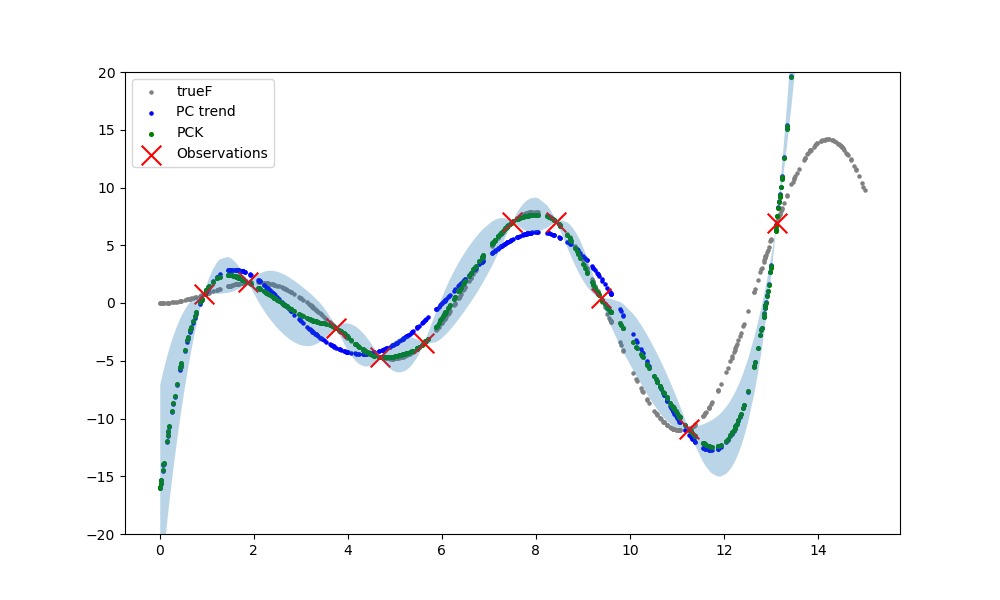

(-20.0, 20.0)

In [584]:
# Mtest=function(XR)

fig = plt.figure(figsize=(10,6))
# ax=fig.add_axes([0,0,1,1])
plt.scatter(XR,Mtest,label=r"trueF",color='grey',s=5)
plt.scatter(XR,mean1,label=r"PC trend",color='blue',s=5)
plt.scatter(XR,PCKmean,label=r"PCK",color='g',s=7)
plt.scatter(xr, y, label="Observations",marker="x",color='r',s=200)
plt.legend(prop={'size': 10})
plt.fill_between(
    a.ravel(),
    b.ravel(),
    c.ravel(),
    alpha=0.3,
    label=r"95% Confidence interval",
)

# plt.xlim([0, 1.75])
plt.ylim([-20.0, 20.0])

<IPython.core.display.Javascript object>


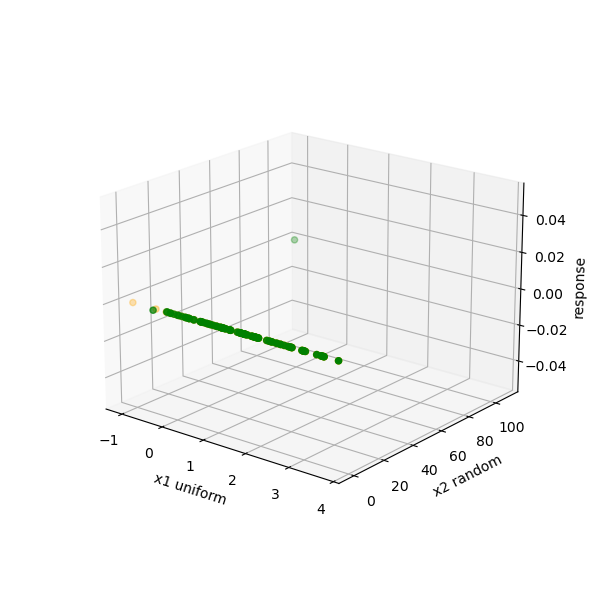

Text(0.5, 0, 'response')

In [103]:
# M=PCE(X1,X2,alpha,Y_)        #predictions on calibrated Y_ coefficients

# MSE_pc=np.sum((Mtest-M)**2)  #MSError - global
# print(MSE_pc)
# print(Y_[0],np.mean(Mtest))  #Coefficient_0 vs mean

%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1r,Mtest, color='green')  # TEST VALUES
# ax.scatter(x1r,x2r,y, 'r')
ax.scatter(X1r,PCKmean, color='orange') # PREDICTIONS
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

# Kriging Model - 2 input var

In [304]:
KrigMean, variaDiag = gaussian_process.predict(XR, return_std=True)

In [303]:


#-----------------------------------------------------COVARIANCE matrices
cov_nn = euclid(distance(xr,xr),l,sig)    #covariance between observations
cov_xn = euclid(distance(XR,xr),l,sig)    #covariance with new points

cov_mult=np.matmul(cov_xn,np.linalg.inv(cov_nn))   #  r'(x) * R^-1
KrigMean=np.matmul(cov_mult,(y))         #Zero prior mean GP

#Variance prediction -------------------------------------------------

cov_xx=euclid(distance(XR,XR),l,sig)
variance=np.subtract(cov_xx,np.matmul(cov_mult,cov_xn.transpose())) 
variaDiag=np.diagonal(variance)    #extracting main diagonal 

# graph_scale = 5
# ymin=(PCK - graph_scale*variaDiag).reshape(-1,1)        #to plot + variance 
# ymax=(PCK + graph_scale*variaDiag).reshape(-1,1)        #to plot - variance 

MSE_krig 73.93904554782836


<IPython.core.display.Javascript object>


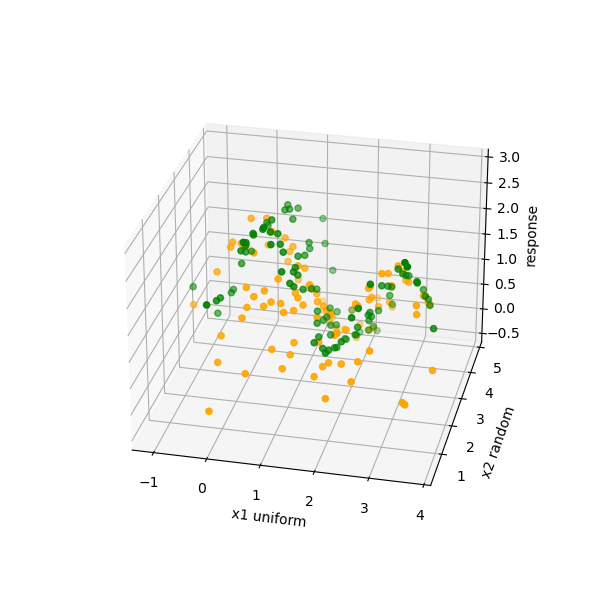

Text(0.5, 0, 'response')

In [305]:
MSE_krig=np.sum((Mtest-KrigMean)**2)  #MSError - global
print('MSE_krig',MSE_krig)

%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
# ax.scatter(xr[:,0],xr[:,1],y, 'blue')
ax.scatter(XR[:,0],XR[:,1],KrigMean, color='orange') 
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

<IPython.core.display.Javascript object>


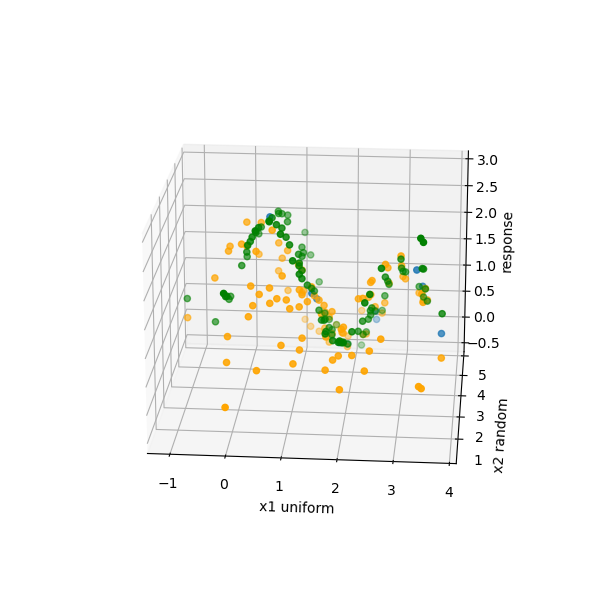

Text(0.5, 0, 'response')

In [309]:
#KRIGING SCIKIT LEARN---------------------------------------------------------------------
mean_prediction, std_prediction = gaussian_process.predict(XR, return_std=True)

# MSE_krig_scik=np.sum((Mtest-mean_prediction)**2)
# print(MSE_krig_scik)


%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
ax.scatter(xr[:,0],xr[:,1],y, 'blue')
ax.scatter(XR[:,0],XR[:,1],mean_prediction, color='orange') 
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

In [455]:
mean_prediction.shape

(90000,)

# PC-Kriging - 2 input var

MSE_PCK 1.635045091707189


<IPython.core.display.Javascript object>


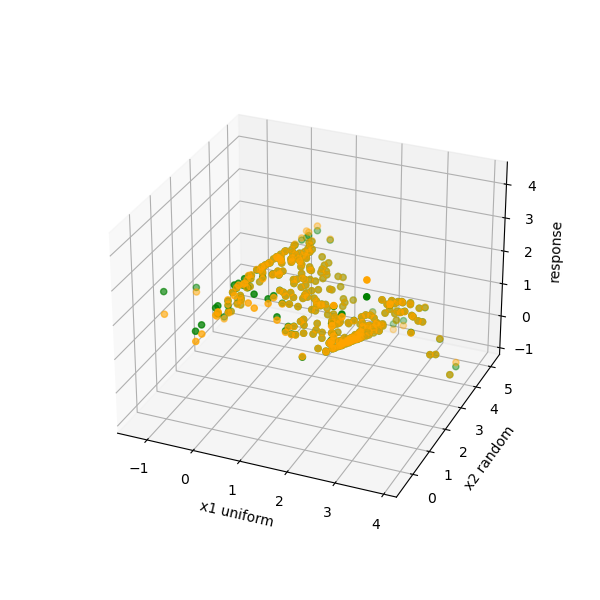

Text(0.5, 0, 'response')

In [443]:
#KRIGING SCIKIT LEARN---------------------------------------------------------------------
# mean_prediction, std_prediction = gaussian_process.predict(Xt, return_std=True)

KrigMean_corr=GaussianPred(XR,xr,y,phi,Y_,l,sig)  #updated GP mean prediction

PCK=M+KrigMean_corr[0]

#Global MSError -------------------------------------------------
MSE_PCK=np.sum((Mtest-PCK)**2)
print('MSE_PCK',MSE_PCK)

#Plot -------------------------------------------------
%matplotlib notebook 
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1],Mtest, color='green')
ax.scatter(XR[:,0],XR[:,1],PCK, color='orange')
# ax.scatter(xr[:,0],xr[:,1],y, 'blue')
# ax.scatter(XR[:,0],XR[:,1],ymin, color='gray')    #variance prediction is required
# ax.scatter(XR[:,0],XR[:,1],ymax, color='gray')

ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

In [444]:
X1t,X2t = np.meshgrid(np.sort(X1r), np.sort(X2r))
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2)

storage=[]

for i in range (0,len(Xt)):
    storage.append(GaussianPred(Xt[i].reshape(-1,2),xr,y,phi,Y_,l,sig))

# arr=np.array(storage)
Krig_gsys_Mean=np.array(storage)[:,0]
Krig_gsys_Var=np.array(storage)[:,1]

In [460]:
%%time
Krig_gsys_Mean= GaussianPred(Xt,xr,y,phi,Y_,l,sig)

KeyboardInterrupt: 

In [456]:
Krig_gsys_Mean=mean_prediction

In [457]:
# fig =plt.subplots(figsize=(10, 6), dpi=80)

X1m,X2m = np.meshgrid(np.sort(X1), np.sort(X2))
Xtm=np.stack((X1m,X2m),axis=2).reshape(-1,2)

PC_gsys_m=PCE(np.sort(Xtm[:,0]),np.sort(Xtm[:,1]),alpha,Y_) 

# ytm=          /  (Xtm)
# gsysm=ytm[0].reshape(ntest,-1)
# cbar=plt.colorbar(cs)

# gsys_m=(Krig_gsys_m[0]+PC_gsys_m).reshape(ntest,-1)
gsys_m=(np.squeeze(Krig_gsys_Mean)+PC_gsys_m).reshape(ntest,-1)

<IPython.core.display.Javascript object>


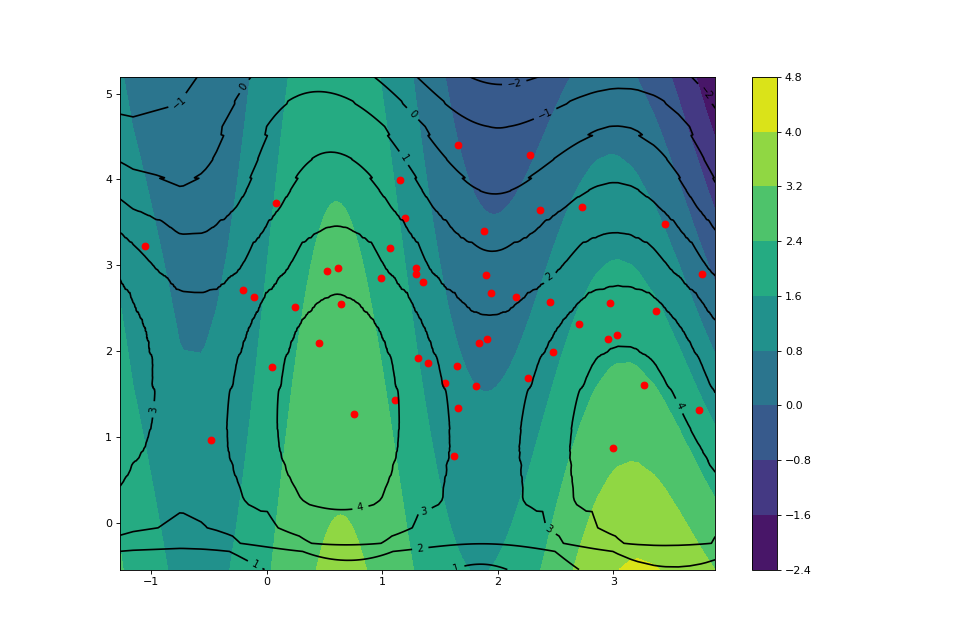

In [458]:
fig =plt.subplots(figsize=(12, 8), dpi=80)

X1t,X2t = np.meshgrid(np.sort(X1r), np.sort(X2r))
Xt=np.stack((X1t,X2t),axis=2).reshape(-1,2)
yt=gfun_53(Xt)

gsys=yt[0].reshape(ntest,-1)

levels = 7
cs = plt.contourf(np.sort(X1r), np.sort(X2r), gsys, levels)
cbar=plt.colorbar(cs)

csm = plt.contour(np.sort(X1r), np.sort(X2r), gsys_m,levels, colors='k')
plt.clabel(csm, fontsize=9, inline=1)

plt.scatter(x1r,x2r,color='red')

cs.changed()

In [179]:
# plt.rcParams['contour.negative_linestyle'] = 'solid'
# # fig =plt.subplots(figsize=(10, 6), dpi=80)
# plt.figure()
# csm = plt.contour(np.sort(X1r), np.sort(X2r), gsys_m, colors='k')
# plt.clabel(csm, fontsize=9, inline=1)
# csm.changed()

# LeaveOneOut_CrossValidation

In [10]:
PC_loo=np.zeros(n)
KrigMeanloo=np.zeros(n)
KrigVarloo=np.zeros(n)
PC_looALL=np.zeros((n,ntest))
KrigMeanlooALL=np.zeros((n,ntest))
KrigVarlooALL=np.zeros((n,ntest))

#Generating PCK models for each reduced design of experiments 
for i in range (0,n):             
    y_loo=np.delete(y,[i])                              #y_n-i     leaving element i out the observations (M)
    xr_loo=np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the hermite inputs (xi)
    xn_loo=np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the inputs (xi)

    #Sampling matrix (A matrix) evaluation of the samples in a sparse p polynomials matrix from PCE
   
    A1_loo = np.zeros((n-1, p+1))
    A2_loo = np.zeros((n-1, p+1))
    phi_loo = np.zeros((n-1, len(alpha)))
    
    #generation of all orthogonal polynomials with degree smaller than p for each variable

    for j in range (0,n-1):
        for k in range (0,p+1):
            A1_loo[j,k] = np.array([M1(xn[j,0],k)])    #legendre

    for j in range (0,n-1):
        for k in range (0,p+1):
            A2_loo[j,k] = np.array([M2(xn[j,1],k)])    #hermite
    #-------------------------------------------------------------------------
    #Learning coefficients by Least-Square Minimization
    
    for j in range (0,n-1):
        for k in range (0,len(alpha)):
            phi_loo[j,k]=A1[j,alpha[k,0]]*A2[j,alpha[k,1]]  

    phi_tr_loo=phi_loo.transpose()
    phi_Inv_loo=np.linalg.inv(np.matmul(phi_tr_loo, phi_loo))
    Inv_phi_trans_loo=np.matmul(phi_Inv_loo,phi_tr_loo)
    Y_loo=np.matmul(Inv_phi_trans_loo,y_loo)     #coefficients for PC =f(M) observations
            
    # PCE mean prediction --------------leaving i-term out
    PC_loo[i] = PCE(xn[i,0],xn[i,1],alpha,Y_loo)       #Predictions on single i-point out following coefficients LOO
    PC_looALL[i] = PCE(X1,X2,alpha,Y_loo)              #Predictions on ALL test points following coefficients LOO
    
    # KRIGING mean--------------leaving i-term out
    [KrigMeanloo[i],KrigVarloo[i]]=GaussianPred(xr[i].reshape(-1,dim),xr_loo,y_loo,phi_loo,Y_loo,l,sig)    #Predictions on single i-point out following coefficients LOO
    [KrigMeanlooALL[i],KrigVarlooALL[i]]=GaussianPred(XR,xr_loo,y_loo,phi_loo,Y_loo,l,sig)                      #Predictions on ALL test points following coefficients LOO
    
mean_loo=PC_loo+KrigMeanloo
# e_loo=(M-mean_loo)**2
# sumat=np.divide(e_loo,KrigVarloo)
mean_looALL=PC_looALL+KrigMeanlooALL

# LOOCV=np.zeros(predict)
# cell=np.zeros(predict)
# for k in range (0,predict):  
#     voro = VoronoiCell(t2[k],xn)
#     LOOCV[k]= variaDiag[k]*(1+sumat[voro])
# #     cell[k] = voro

<IPython.core.display.Javascript object>


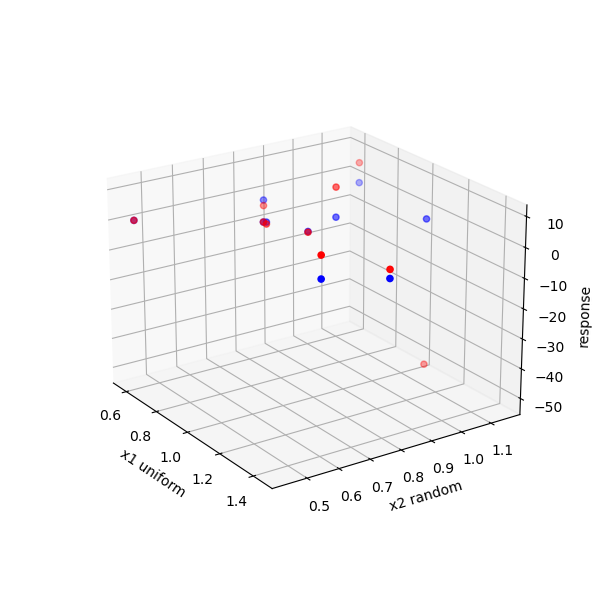

Text(0.5, 0, 'response')

In [11]:
#Plot -------------------------------------------------
%matplotlib notebook
# i=3                         # i-out observation to see the response surface shape

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xr[:,0],xr[:,1],y, color='blue')                 #observations
ax.scatter(xr[:,0],xr[:,1],mean_loo, color='red')           #leave-one-out predictions
# ax.scatter(X1r,X2r,mean_looALL[i], color='red')           #to plot the response surface shape leaving i out
ax.set_xlabel('x1 uniform')
ax.set_ylabel('x2 random')
ax.set_zlabel('response')

In [43]:
phi.shape

(10, 10)

In [49]:
xr[:,0]

array([3.26405235, 1.90015721, 2.47873798, 3.7408932 , 3.36755799,
       0.52272212, 2.45008842, 1.34864279, 1.39678115, 1.9105985 ])

In [57]:
from sklearn import linear_model
reg = linear_model.Lars(n_nonzero_coefs=5, normalize=False, precompute='auto')
# reg.fit([xr[:,0],xr[:,1]],y)
reg.fit(xr,y)
# ([[0, 0], [1, 1]], [0, 1])

Lars(n_nonzero_coefs=5, normalize=False)

In [60]:
from sklearn.linear_model import LarsCV

LarsCV(fit_intercept=False, max_iter=5).fit(xr,y)

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LarsCV(fit_intercept=False, max_iter=5)

In [59]:
lars

LarsCV(fit_intercept=False, max_iter=5)

In [54]:
# Lars(n_nonzero_coefs=1, normalize=False)
print(reg.coef_)

[-0.22368783 -0.44014654]


In [17]:
x_0=np.array([[-1, 1], [0, 0], [1, 1]])
y_0=np.array([-1.1111, 0, -1.1111])

In [18]:
x_0, y_0

(array([[-1,  1],
        [ 0,  0],
        [ 1,  1]]),
 array([-1.1111,  0.    , -1.1111]))

In [19]:
([[0, 0], [1, 1]], [0, 1])

[1]


<IPython.core.display.Javascript object>


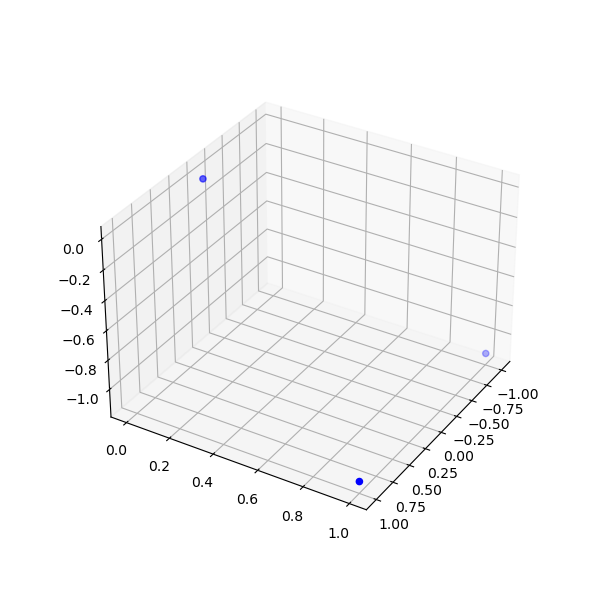

In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_0[:,0],x_0[:,1],y_0, color='blue') 

In [15]:
# x = np.array([0,0])
# cov = np.array([[1,  0], 
#                 [0 , 1]])  # diagonal covariance
# C=(2.4**2/len(x))*cov    # Gelman [2014]

# xn=np.random.multivariate_normal(x, C, n).T

# x1r=scalehermite(xn[:,0],x1mean,x1sigma)  #values to evaluate real function
# x1r=scalehermite(xn[:,1],x1mean,x1sigma)  #values to evaluate real function